In [1]:
#!pip install medmnist

In [2]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

In [3]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.2 @ https://github.com/MedMNIST/MedMNIST/


# We work on the 2D dataset with size 28x28

In [4]:
data_flag = 'bloodmnist'
download = True
BATCH_SIZE = 128

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

## First, we read the MedMNIST data, preprocess them and encapsulate them into dataloader form.

In [5]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

In [6]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset BloodMNIST of size 28 (bloodmnist)
    Number of datapoints: 11959
    Root location: C:\Users\pedro\.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}
    Number of samples: {'train': 11959, 'val': 1712, 'test': 3421}
    Description: The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.
    Lice

In [7]:
# visualization

train_dataset.montage(length=1)



c:\Users\pedro\anaconda3\lib\site-packages\medmnist\utils.py:32: FutureWarning: `multichannel` is a deprecated argument name for `montage`. It will be removed in version 1.0. Please use `channel_axis` instead.
  montage_arr = skimage_montage(sel_img, multichannel=(n_channels == 3))


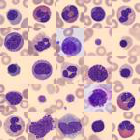

In [8]:

train_dataset.montage(length=5)

In [9]:
#Access a single image / label
image, label = train_dataset[2]  # image is a tensor , label is an  int
print("Shape da imagem:", image.shape)
print("Classe:", label)

# Convert to NumPy array
image_array = image.numpy()
print("Size:", image_array.shape )

#Access a subset of images
img = train_dataset[1][0].numpy   # image
lab = train_dataset[1][1]   # label
start_idx = 10
end_idx = 20  # exclusive
images_array = np.stack([train_dataset[i][0].numpy() for i in range(start_idx, end_idx)])
labels_array = np.array([train_dataset[i][1] for i in range(start_idx, end_idx)])

print("Size:", images_array.shape )
print(labels_array)




Shape da imagem: torch.Size([3, 28, 28])
Classe: [6]
Size: (3, 28, 28)
Size: (10, 3, 28, 28)
[[1]
 [1]
 [6]
 [7]
 [6]
 [3]
 [7]
 [2]
 [6]
 [1]]


## Flatten
Aqui vamos transformar os dados em tipo numpy e dar flatten aos inputs como precisam de ser vetores 1D e não imagens

In [10]:
# Transformação dos datasets em inputs e outputs
x_train = train_dataset.imgs
y_train = train_dataset.labels
x_test = test_dataset.imgs
y_test = test_dataset.labels

# Converter para arrays NumPy (caso ainda sejam tensores)
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

# Flatten
x_train = x_train.reshape(x_train.shape[0], -1) 
x_test = x_test.reshape(x_test.shape[0], -1)

# Converter outra vez para tensors
x_train = torch.tensor(x_train).float()
y_train = torch.tensor(y_train).long()

x_test = torch.tensor(x_test).float()
y_test = torch.tensor(y_test).long()

num_inputs = x_train.shape[1]

In [11]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():    
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Implementação da DNN

In [ ]:
class DNN(nn.Module): #mudar
    def __init__(self, input_size , hidden_sizes, num_classes = n_classes):
        super(DNN, self).__init__()
        self.layers = nn.ModuleList()
        self.activations = nn.ModuleList()

        if len(hidden_sizes) == 0:
            self.layers.append(nn.Linear(input_size, num_classes))
        else:
            self.layers.append(nn.Linear(input_size, hidden_sizes[0]))
            self.activations.append(nn.ReLU())        
        
            for i in range(len(hidden_sizes)-1):
                self.layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
                self.activations.append(nn.ReLU())

            self.layers.append(nn.Linear(hidden_sizes[-1], num_classes))
    
    def forward(self, x):
        #TODO: implement the forward pass
        out = x
        for i in range(len(self.layers)): # All layers
            out = self.layers[i](out) # out = W out
            if i < len(self.activations):
                out = self.activations[i](out) # out = activation(out)
        return out

